<a href="https://colab.research.google.com/github/GuQiangJS/reading-notes/blob/master/Python%20for%20Finance/%E5%88%86%E7%B1%BB_SVM%EF%BC%88%E6%94%AF%E6%8C%81%E5%90%91%E9%87%8F%E6%9C%BA%EF%BC%89_%E4%BA%8C%E5%88%86%E7%B1%BB%EF%BC%88LinearSVC%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

采用 `sklearn.svm.LinearSVC` 支持向量机进行二元分类测试。

本次测试的准确率只有 `51%`。并且没有划分训练集和测试集。

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

sns.set(style="ticks")

In [22]:
df=pd.read_csv('https://raw.githubusercontent.com/GuQiangJS/temp/master/600036.csv',index_col=0,parse_dates=True)
df.head()

,code,open,high,low,close,volume,amount,preclose,adj
date,,,,,,,,,
2002-04-09,600036,2.198710,2.276115,2.198710,2.230091,1.979471e+07,4.418822e+09,NaN,0.209202
2002-04-10,600036,2.230091,2.238459,2.173606,2.217539,3.247841e+06,7.166843e+08,2.230091,0.209202
2002-04-11,600036,2.217539,2.234275,2.194526,2.200802,1.089293e+06,2.409635e+08,2.217539,0.209202
2002-04-12,600036,2.196618,2.225907,2.192434,2.211263,1.016072e+06,2.240599e+08,2.200802,0.209202
2002-04-15,600036,2.211263,2.217539,2.165238,2.173606,8.858004e+05,1.933069e+08,2.211263,0.209202


In [0]:
# np.log(30.282827/30.082837)#0.006626，
# np.log(30.015684/30.282827)#-0.008861

In [0]:
# def daily_return(data,column='close',day=1,log=True):
#     result=data[column]/data[column].shift(day)
#     return np.log(result) if log else result

# daily_return(df).head()

# df['close'].shift(1)/df['close'].shift(2)

1. 采用原始数据中的 `close` 和 `preclose`。
2. 使用 `close - preclose` 计算当日日回报。
3. 取前一日的 `close` （*`df['close'].shift(1)`*）与前 `i` 日的 `close` （*`df['close'].shift(i)`*) 计算特征值。总共计算 向前倒退 `DAYS`-1 日。并对结果取对数 `np.log`，对对数结果取 `np.sign`，将值限定在 `[-1,1]`。
    > The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0. nan is returned for nan inputs.
4. 丢弃掉计算结果中有 `nan` 的值。
5. 同样对当日回报取 `np.sign`。（后面用来与训练结果比较）

In [25]:
df_new=df[['close','preclose']]
df_new['Returns']=df_new['close']-df_new['preclose']
DAYS=10
COLUMNS=[]
for i in range(2,DAYS):
    # 取前一天开始往前推 DAYS 天数的收益率结果。
    # 对收益率取对数后，使用 np.sign 进行正则化
    df_new['tag_{}'.format(i)]=np.sign(np.log(df['close'].shift(1)/df['close'].shift(i)))
    COLUMNS.append('tag_{}'.format(i))

df_new.dropna(inplace=True)
df_new['Real']=np.sign(df_new['Returns'])
df_new.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,close,preclose,Returns,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,Real
date,,,,,,,,,,,,
2002-04-22,2.094110,2.121306,-0.027196,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2002-04-23,2.092018,2.094110,-0.002092,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2002-04-24,2.043901,2.092018,-0.048116,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2002-04-25,2.052269,2.043901,0.008368,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2002-04-26,2.058545,2.052269,0.006276,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2002-04-29,2.060637,2.058545,0.002092,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2002-04-30,2.096202,2.060637,0.035564,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2002-05-08,2.071097,2.096202,-0.025104,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0
2002-05-09,2.079465,2.071097,0.008368,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0


采用 `sklearn.svm.LinearSVC` 默认方法进行计算。

`x`：上一步计算出的特征值。

`y`：对当日日回报进行 `np.sign`，将值限定在 [-1,1]。**二分类**

In [26]:
model=LinearSVC()
model.fit(df_new[COLUMNS],np.sign(df_new['Returns']))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

对所有样本进行分类。

In [27]:
df_new['Predict']=model.predict(df_new[COLUMNS])
df_new.head(10)

,close,preclose,Returns,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,Real,Predict
date,,,,,,,,,,,,,
2002-04-22,2.094110,2.121306,-0.027196,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2002-04-23,2.092018,2.094110,-0.002092,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2002-04-24,2.043901,2.092018,-0.048116,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2002-04-25,2.052269,2.043901,0.008368,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
2002-04-26,2.058545,2.052269,0.006276,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
2002-04-29,2.060637,2.058545,0.002092,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
2002-04-30,2.096202,2.060637,0.035564,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
2002-05-08,2.071097,2.096202,-0.025104,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
2002-05-09,2.079465,2.071097,0.008368,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0


使用分类结果 `Predict` 乘以当日的正常回报 `Returns` = `Strategy`。记为按照本次策略操作后的回报率。

|Predict|Returns|Strategy||
|---|---|---|---|
|`<0`|`<0`|`>0`|买对了|
|`>0`|`>0`|`>0`|买对了|
|`>0`|`<0`|`<0`|买错了|
|`<0`|`>0`|`>0`|买错了|

通过观察 `Real` 和 `Predict` 也可以看出预测是正确还是错误。

In [28]:
df_new['Strategy']=df_new['Returns']*df_new['Predict']
df_new.head(10)

,close,preclose,Returns,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,Real,Predict,Strategy
date,,,,,,,,,,,,,,
2002-04-22,2.094110,2.121306,-0.027196,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.027196
2002-04-23,2.092018,2.094110,-0.002092,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-0.002092
2002-04-24,2.043901,2.092018,-0.048116,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-0.048116
2002-04-25,2.052269,2.043901,0.008368,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,0.008368
2002-04-26,2.058545,2.052269,0.006276,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-0.006276
2002-04-29,2.060637,2.058545,0.002092,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-0.002092
2002-04-30,2.096202,2.060637,0.035564,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-0.035564
2002-05-08,2.071097,2.096202,-0.025104,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,0.025104
2002-05-09,2.079465,2.071097,0.008368,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,0.008368


实际日回报和使用策略的日回报的累加结果比较。

In [29]:
df_new[['Returns','Strategy']].cumsum().tail()

,Returns,Strategy
date,,
2019-06-17,33.478694,7.990887
2019-06-18,33.898694,7.570887
2019-06-19,34.678694,6.790887
2019-06-20,36.258694,5.210887
2019-06-21,35.568694,5.900887


In [30]:
print('平均准确度:',model.score(df_new[COLUMNS],np.sign(df_new['Returns'])))

平均准确度: 0.51806640625


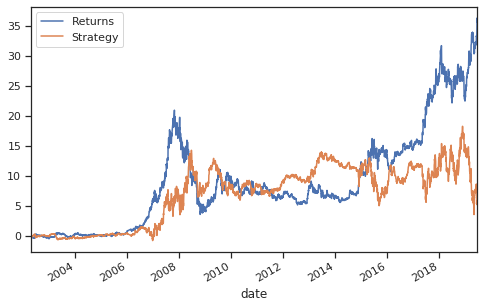

In [31]:
df_new[['Returns','Strategy']].cumsum().plot(figsize=(8,5))

In [0]:
# def test(**kwargs):
#     df_new=df[['close','preclose']]
#     df_new['Returns']=df_new['close']-df_new['preclose']
#     DAYS=10
#     COLUMNS=[]
#     for i in range(2,DAYS):
#         df_new['tag_{}'.format(i)]=np.sign(np.log(df['close'].shift(1)/df['close'].shift(i)))
#         COLUMNS.append('tag_{}'.format(i))

#     df_new.dropna(inplace=True)
#     df_new['Real']=np.sign(df_new['Returns'])

#     model=LinearSVC(**kwargs)
#     model.fit(df_new[COLUMNS],np.sign(df_new['Returns']))

#     df_new['Predict']=model.predict(df_new[COLUMNS])
#     df_new['Strategy']=df_new['Returns']*df_new['Predict']

#     title=kwargs.pop('title','')
#     plot=kwargs.pop('plot',False)
#     print(title)
#     print('最后一笔:',df_new[['Returns','Strategy']].cumsum().tail(1))

#     print('平均准确度:',model.score(df_new[COLUMNS],np.sign(df_new['Returns'])))
#     if plot:
#         df_new[['Returns','Strategy']].cumsum().plot(figsize=(8,5),title=title)

In [0]:
# test(loss='hinge')

In [0]:
# LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#           verbose=0)